In [2]:
import torch
import time
n = 1000
a= torch.ones(n)
b=torch.ones(n)

In [4]:
'''define a timer class to record time'''
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times=[]
        self.start()
    
    def start(self):
        #start the timer
        self.start_time = time.time()
    def stop(self):
         #stop a timer and record a time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]
    def avg(self):
        return sum(self.times)/len(self.times)
    def sum(self):
        return sum(self.times)
    

In [6]:
timer=Timer()
c=torch.zeros(n)
for i in range(n):
    c[i]=a[i]+b[i]
print('%.5fsec' %timer.stop())


0.02396sec


In [8]:

timer.start()
d = a + b
print('%.101f sec' % timer.stop())

0.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000 sec


In [10]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)



1.4.0


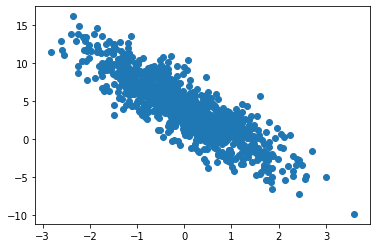

In [39]:
# set input feature number 
num_inputs = 2
# set example number
num_examples = 1000

# set true weight and bias in order to generate corresponded label
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs,dtype=torch.float32)
l=features[:,0]
lables = true_w[0]*features[:,0] + true_w[1]*features[:,1]+true_b
lables += torch.tensor(np.random.normal(0, 0.01, size=lables.size()), dtype=torch.float32)
def use_svg_display():
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize']=figsize
plt.scatter(features[:,1].numpy(),lables.numpy())


In [41]:
''' 
Batch 的选择，首先决定的是下降的方向。如果数据集比较小，完全可以采用全数据集 （ Full Batch Learning ）的形式，这样做至少有 2 个好处：其一，由全数据集确定的方向能够更好地代表样本总体，从而更准确地朝向极值所在的方向。其二，由于不同权重的梯度值差别巨大，因此选取一个全局的学习率很困难。 Full Batch Learning 可以使用 Rprop 只基于梯度符号并且针对性单独更新各权值。

对于更大的数据集，以上 2 个好处又变成了 2 个坏处：其一，随着数据集的海量增长和内存限制，一次性载入所有的数据进来变得越来越不可行。其二，以 Rprop 的方式迭代，会由于各个 Batch 之间的采样差异性，各次梯度修正值相互抵消，无法修正。这才有了后来 RMSProp 的妥协方案。
'''
'''
读取数据集
'''
def data_iter(batch_size,features,lables):
    num_examples=len(features)
    indices=list(range(num_examples))
    random.shuffle(indices)#打乱初始构造的数据
    print(indices)
    for i in range(0,num_examples,batch_size):
        j=torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        print(j)
        yield  features.index_select(0,j),lables.index_select(0,j)

In [43]:
batch_size = 10

for X, y in data_iter(batch_size, features, lables):
    print(X, '\n', y)
    break

[755, 860, 510, 598, 426, 313, 896, 689, 783, 189, 786, 272, 659, 782, 990, 50, 196, 494, 635, 408, 194, 849, 867, 424, 866, 442, 225, 766, 136, 870, 694, 753, 771, 18, 62, 861, 573, 51, 805, 324, 67, 257, 560, 567, 283, 518, 480, 350, 612, 124, 427, 361, 886, 450, 299, 856, 685, 571, 738, 96, 221, 594, 98, 368, 985, 535, 356, 152, 550, 32, 42, 90, 258, 548, 636, 961, 704, 28, 619, 2, 290, 773, 994, 515, 303, 0, 908, 417, 965, 251, 337, 629, 130, 231, 695, 20, 485, 952, 983, 693, 301, 586, 329, 858, 655, 761, 298, 423, 540, 681, 726, 868, 680, 833, 632, 400, 626, 806, 677, 145, 127, 439, 187, 271, 477, 177, 198, 905, 429, 767, 70, 637, 938, 840, 470, 118, 928, 451, 565, 531, 207, 777, 792, 29, 645, 432, 559, 103, 975, 53, 927, 683, 325, 554, 215, 944, 41, 478, 156, 182, 769, 819, 45, 740, 434, 919, 175, 359, 453, 577, 358, 960, 249, 488, 236, 443, 935, 133, 139, 724, 372, 708, 264, 243, 556, 109, 389, 31, 616, 154, 373, 263, 593, 660, 12, 633, 638, 504, 191, 312, 614, 526, 538, 168, 37

In [45]:
'''
初始化模型参数
'''
w=torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),dtype=torch.float32)
b=torch.zeros(1,dtype=torch.float32)
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)


tensor([0.], requires_grad=True)


In [51]:
#构造模型
def linreg(X, w, b):
    return torch.mm(X, w) + b

#构造损失函数
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

#定义优化函数
def sgd(params, lr, batch_size): 
    for param in params:
        param.data -= lr * param.grad / batch_size # ues .data to operate param without gradient track
#参数初始化
lr=0.03
num_epochs=5

net=linreg
loss=squared_loss

In [49]:
# training

for epoch in range(num_epochs):  # training repeats num_epochs times
    # in each epoch, all the samples in dataset will be used once
    
    # X is the feature and y is the label of a batch sample
    for X, y in data_iter(batch_size, features, lables):
        l = loss(net(X, w, b), y).sum()  
        # calculate the gradient of batch sample loss 
        l.backward()  
        # using small batch random gradient descent to iter model parameters
        sgd([w, b], lr, batch_size)  
        # reset parameter gradient
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), lables)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

[99, 951, 111, 118, 853, 142, 115, 995, 919, 581, 660, 669, 811, 287, 304, 570, 762, 607, 34, 107, 276, 467, 97, 208, 562, 743, 427, 586, 489, 585, 934, 713, 333, 645, 732, 218, 842, 282, 894, 563, 122, 577, 59, 821, 9, 936, 347, 703, 904, 293, 969, 351, 845, 214, 627, 705, 761, 712, 902, 673, 616, 642, 511, 239, 778, 569, 665, 859, 765, 979, 432, 947, 653, 234, 641, 284, 74, 448, 298, 691, 151, 914, 516, 763, 730, 197, 948, 968, 652, 143, 37, 561, 986, 715, 67, 546, 935, 579, 639, 545, 566, 495, 186, 384, 756, 2, 25, 512, 307, 359, 813, 567, 552, 75, 198, 322, 578, 789, 220, 237, 310, 574, 144, 957, 993, 524, 888, 510, 532, 882, 783, 44, 920, 210, 177, 434, 650, 683, 172, 302, 777, 363, 441, 655, 249, 320, 280, 980, 539, 521, 493, 0, 940, 784, 3, 296, 299, 536, 644, 816, 22, 77, 383, 229, 479, 476, 193, 520, 587, 485, 306, 560, 675, 238, 191, 749, 737, 937, 793, 385, 433, 335, 26, 316, 51, 371, 515, 513, 590, 391, 807, 451, 817, 637, 285, 687, 501, 751, 27, 865, 989, 101, 146, 518, 48

In [ ]:
a=torch.tensor([[1,2],[3,4]])
b=torch.tensor([[6],[7]])
print(a,b,torch.mm(a,b))

a=torch.tensor([[-0.4122, -0.1195],
        [ 0.2107, -0.3208],
        [-0.9846, -0.1350],
        [ 0.2695,  0.1817],
        [-1.5354, -0.3564],
        [-0.2621,  0.4991],
        [ 0.4759, -1.3293],
        [-0.6201, -0.3167],
        [ 2.0841, -0.1266],
        [-0.8714, -1.3686]]) 
b=torch.tensor([[ 1.9997],
        [-3.4004]], requires_grad=True)
print(torch.mm(a,b))

tensor([[1, 2],
        [3, 4]]) tensor([[6],
        [7]]) tensor([[20],
        [46]])
tensor([[-0.4179],
        [ 1.5122],
        [-1.5099],
        [-0.0789],
        [-1.8584],
        [-2.2213],
        [ 5.4718],
        [-0.1631],
        [ 4.5981],
        [ 2.9112]], grad_fn=<MmBackward>)
